In [ ]:
# Modelo de Clasificación con hiperparámetros optimizados

!pip install scikit-optimize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 2.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
df = pd.read_csv("/content/Algerian_forest_fires_dataset_CLEAN.csv")
df

,day,month,year,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes
0,1,6,2012,29.0,57.0,18.0,0.0,65.7,3.4,7.6,1.3,3.4,0.5,not fire
1,2,6,2012,29.0,61.0,13.0,1.3,64.4,4.1,7.6,1.0,3.9,0.4,not fire
2,3,6,2012,26.0,82.0,22.0,13.1,47.1,2.5,7.1,0.3,2.7,0.1,not fire
3,4,6,2012,25.0,89.0,13.0,2.5,28.6,1.3,6.9,0.0,1.7,0.0,not fire
4,5,6,2012,27.0,77.0,16.0,0.0,64.8,3.0,14.2,1.2,3.9,0.5,not fire
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238,26,9,2012,30.0,65.0,14.0,0.0,85.4,16.0,44.5,4.5,16.9,6.5,fire
239,27,9,2012,28.0,87.0,15.0,4.4,41.1,6.5,8.0,0.1,6.2,0.0,not fire
240,28,9,2012,27.0,87.0,29.0,0.5,45.9,3.5,7.9,0.4,3.4,0.2,not fire
241,29,9,2012,24.0,54.0,18.0,0.1,79.7,4.3,15.2,1.7,5.1,0.7,not fire


In [ ]:
# Seleccionamos las variables
from sklearn.model_selection import train_test_split
X = df[["Temperature","RH","Ws","Rain","FFMC","DMC","DC","ISI","BUI","FWI"]]
y = df["Classes"]

In [ ]:
print(df["Classes"].value_counts())

Classes
fire             131
not fire         101
fire               4
fire               2
not fire           2
not fire           1
not fire           1
not fire           1
Name: count, dtype: int64


In [ ]:
# Limipieza de datos
df["Classes"]= df["Classes"].str.strip().str.lower()

# Volvemos al conteo
print(df["Classes"].value_counts())

Classes
fire        137
not fire    106
Name: count, dtype: int64


In [ ]:
# Hacemos un mapping de la variable dependiente
df["Classes"]= df["Classes"].map({
    "fire": 1,
    "not fire": 0
})

# Eliminación de valores NaN
df = df.dropna(subset="Classes")

# Comprobación definitiva
print(df["Classes"].value_counts())

Classes
1    137
0    106
Name: count, dtype: int64


In [ ]:
# Redefinimos X e Y
X = df[["Temperature","RH","Ws","Rain","FFMC","DMC","DC","ISI","BUI","FWI"]]
y = df["Classes"]

X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.8,random_state=0)

X_train.shape, y_train.shape


((194, 10), (194,))

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier

armado = Pipeline([
   ('scaler', StandardScaler()),
   ('xgb', XGBClassifier(use_label_encoder = False, eval_metric = 'logloss', random_state=0))
])

In [ ]:
from skopt import BayesSearchCV

parametros = {
    'xgb__max_depth': (3,10),
    'xgb__learning_rate': (0.01, 0.3, 'log-uniform'),
    'xgb__subsample': (0.5,1.0),
    'xgb__n_estimators': (50,300)
}

In [ ]:
 #Optimización bayesiana
opt = BayesSearchCV(
    estimator=armado,
    search_spaces=parametros,
    n_iter=20,
    scoring='accuracy',
    cv=3,
    n_jobs=-1,
    random_state=0
)

# Entrenando el modelo
opt.fit(X_train,y_train)

# Evaluar el modelo

from sklearn.metrics import classification_report, confusion_matrix

y_pred = opt.predict(X_test)

print("Mejores hiperparámetros", opt.best_params_)
print("Reporte de clasifciación", classification_report(y_test,y_pred))
print("Matriz de confusión", confusion_matrix(y_test,y_pred))


Mejores hiperparámetros OrderedDict([('xgb__learning_rate', 0.01651037500373868), ('xgb__max_depth', 8), ('xgb__n_estimators', 167), ('xgb__subsample', 0.7275277083151349)])
Reporte de clasifciación               precision    recall  f1-score   support

           0       1.00      1.00      1.00        23
           1       1.00      1.00      1.00        26

    accuracy                           1.00        49
   macro avg       1.00      1.00      1.00        49
weighted avg       1.00      1.00      1.00        49

Matriz de confusión [[23  0]
 [ 0 26]]


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:40:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [ ]:
# Nuevos datos
nuevos_datos_clas = pd.DataFrame({
  "Temperature": [25,33,22,40,30],
  "RH": [30,15,50,10,45],
  "Ws":[14,10,6,8,7],
  "Rain": [0.0, 0.0, 1.2,0.0,0.5],
  "FFMC":[45,32,62,54,70],
  "DMC":[3.4,4.5,6.9, 7.8, 8.4],
  "DC":[1.2,1.9,2.7,6.8, 4.5],
  "ISI": [0.2,0.55,0.7,1.2,0.8],
  "BUI": [3.5,2.8,5.6,4.2,3.5],
  "FWI": [0.7,2.1,0.2,15.6,3.2]
})

# Predecimos probabilidades
probabilidades = opt.predict_proba(nuevos_datos_clas)

# Construir el nuevo dataframe
df_resultado = nuevos_datos_clas.copy()
df_resultado["Prob_not_fire"] = probabilidades[:, 0]
df_resultado["Prob_fire"] = probabilidades[:, 1]

In [ ]:
df_resultado

,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Prob_not_fire,Prob_fire
0,25,30,14,0.0,45,3.4,1.2,0.20,3.5,0.7,0.950498,0.049502
1,33,15,10,0.0,32,4.5,1.9,0.55,2.8,2.1,0.951439,0.048561
2,22,50,6,1.2,62,6.9,2.7,0.70,5.6,0.2,0.951101,0.048899
3,40,10,8,0.0,54,7.8,6.8,1.20,4.2,15.6,0.944683,0.055317
4,30,45,7,0.5,70,8.4,4.5,0.80,3.5,3.2,0.951101,0.048899


In [ ]:
# Simulaciones de escenarios

simulacion = nuevos_datos_clas.copy()
simulacion["Temperature"] += 8
simulacion["RH"] -=10
simulacion["Ws"] +=8
simulacion["FFMC"] +=20
simulacion["DC"] +=5.0
simulacion["ISI"] +=0.5
simulacion["FWI"] +=5.0


sim_prob = opt.predict_proba(simulacion)
simulacion["prob_fire_sim"]= sim_prob[:,1]

simulacion[["Temperature","RH","prob_fire_sim"]]

,Temperature,RH,prob_fire_sim
0,33,20,0.054511
1,41,5,0.055317
2,30,40,0.364753
3,48,0,0.055317
4,38,35,0.624021


In [ ]:
# Simulación de la temperatura de 100 días
import numpy as np
temp_uniforme = np.random.uniform(20,42, size=100)
temp_normal = np.random.normal(loc=30, scale=12, size= 100)
humedad_uniforme = np.random.uniform(20,50, size=100)
humedad_normal = np.random.normal(loc=40, scale=10, size= 100)

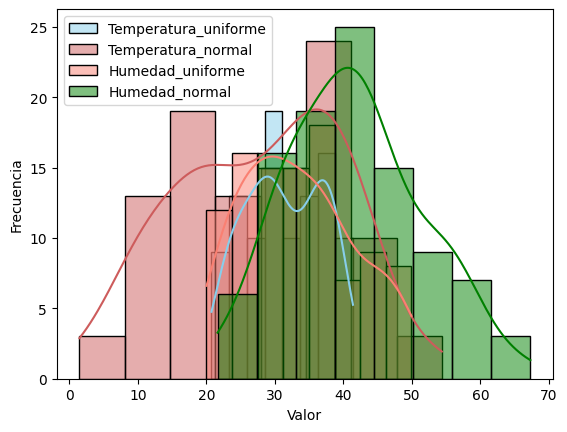

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(temp_uniforme, kde=True, color="skyblue", label="Temperatura_uniforme")
sns.histplot(temp_normal, kde=True, color="indianred", label="Temperatura_normal")
sns.histplot(humedad_uniforme, kde=True, color="salmon", label="Humedad_uniforme")
sns.histplot(humedad_normal, kde=True, color="green", label="Humedad_normal")
plt.legend()
plt.xlabel("Valor")
plt.ylabel("Frecuencia")
plt.show()



In [ ]:
# Nuevas simulaciones
simulados = pd.DataFrame({
  "Temperature": np.random.uniform(20,42, size=5),
  "RH": np.random.normal(loc=40, scale=10, size= 5),
  "Ws":np.random.normal(loc=10, scale=5, size= 5),
  "Rain": [0.0, 0.0, 1.2,0.0,0.5],
  "FFMC":[45,32,62,54,70],
  "DMC":[3.4,4.5,6.9, 7.8, 8.4],
  "DC":[1.2,1.9,2.7,6.8, 4.5],
  "ISI": [0.2,0.55,0.7,1.2,0.8],
  "BUI": [3.5,2.8,5.6,4.2,3.5],
  "FWI": [5.7,7.1,5.2,20.6,8.2]
})

# Asegurarnos de que no haya valores por fuera el rango
simulados["RH"]= simulados["RH"].clip(30,50)

In [ ]:
# Predecimos probabilidades
probabilidades_sim = opt.predict_proba(simulados)

# Construir el nuevo dataframe
df_resultado_sim = simulados.copy()
df_resultado_sim["Prob_not_fire"] = probabilidades_sim[:, 0]
df_resultado_sim["Prob_fire"] = probabilidades_sim[:, 1]
df_resultado_sim

,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Prob_not_fire,Prob_fire
0,35.034311,47.548869,12.545419,0.0,45,3.4,1.2,0.20,3.5,5.7,0.944683,0.055317
1,34.128914,31.800126,10.934312,0.0,32,4.5,1.9,0.55,2.8,7.1,0.945489,0.054511
2,41.062117,46.818687,10.729556,1.2,62,6.9,2.7,0.70,5.6,5.2,0.944683,0.055317
3,34.643801,43.968866,7.128539,0.0,54,7.8,6.8,1.20,4.2,20.6,0.945489,0.054511
4,39.839324,36.446074,4.328017,0.5,70,8.4,4.5,0.80,3.5,8.2,0.944683,0.055317
